In [1]:
import modin.pandas as pd

from cryptsmash.utils import inv_chi_squared, frequency_table, index_of_coincidence, ngram_count, entropy
from cryptsmash.plaintext import English

In [2]:
# https://www.kaggle.com/datasets/mikeortman/wikipedia-sentences
with open("wikisent2.txt", 'r') as f:
    sentences = f.read().split("\n")

df = pd.DataFrame(sentences, columns=['plaintext'])
alphabet = set(['\n'])

# https://www.kaggle.com/datasets/alvations/old-newspapers
# cat old-newspaper.tsv| awk -F "\t" '{if($1=="English"){print $4}}' | tee english-newspaper.txt
with open("english-newspaper.txt", 'r', newline='') as f:
    data = f.read().split("\n")

data = data

for sentence in data:
    for char in sentence:
        alphabet.add(char)

df = pd.concat([pd.DataFrame({'plaintext': data}),  ], ignore_index=True)

# df = df.sample(frac=.001, random_state=1337)

# Clean up some stuffs
del sentences
del sentence
del data


To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

2024-03-11 23:32:07,525	INFO worker.py:1724 -- Started a local Ray instance.
(_deploy_ray_func pid=9219) RuntimeWarning: divide by zero encountered in log2
(_deploy_ray_func pid=9219) RuntimeWarning: invalid value encountered in multiply
(_deploy_ray_func pid=9228) RuntimeWarning: divide by zero encountered in log2
(_deploy_ray_func pid=9228) RuntimeWarning: invalid value encountered in multiply
(_deploy_ray_func pid=9233) RuntimeWarning: divide by zero encountered in log2
(_deploy_ray_func pid=9233) RuntimeWarning: invalid value encountered in multiply
(_deploy_ray_func pid=9225) RuntimeWarning: divide by zero encountered in log2
(_deploy_ray_func pid=9225) RuntimeWarning: invalid value encountered in multiply
(_deploy_ray_func pid=9228) RuntimeWarning: divide by zero encountered in log2
(_deploy_ray_func pid=9228) RuntimeWarning: invalid value encountered in multip

In [3]:
df['plain_len'] = df.apply(lambda r: len(r['plaintext']), axis=1)
# At least 5 letter cipher (which is pretty short anyways)
df = df[df['plain_len'] > 4]
df.info()


<class 'modin.pandas.dataframe.DataFrame'>
Index: 1009808 entries, 0 to 1010241
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   plaintext  1009808 non-null  object
 1   plain_len  1009808 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 23.1+ MB


In [4]:
df['plain_chisq'] = df.apply(lambda r: inv_chi_squared(frequency_table(r['plaintext']), English.byte_distrib, r['plain_len']), axis=1)
# df['plain_bigram_chisq'] = df.apply(lambda r: inv_chi_squared(ngram_count(r['plaintext'], 2), English.bigrams, r['plain_len']-2), axis=1)
df['plain_ioc'] = df.apply(lambda r: index_of_coincidence(r['plaintext']), axis=1)
df['plain_entropy'] = df.apply(lambda r: entropy(bytes(r['plaintext'], 'utf8')), axis=1)
# df.head()

In [5]:
df.describe().apply(lambda s: s.apply(lambda x:format(x,'f')))

,plain_len,plain_chisq,plain_ioc,plain_entropy
count,1009808.000000,1009808.000000,1009808.000000,1009808.000000
mean,202.352052,0.002670,0.062382,0.531548
std,133.547487,0.003913,0.011326,0.032523
min,5.000000,0.000024,0.000000,-0.000000
25%,111.000000,0.000999,0.059226,0.521704
50%,186.000000,0.001444,0.063966,0.535966
75%,269.000000,0.002418,0.067953,0.548883
max,11384.000000,0.051053,1.000000,0.714175


In [6]:
df.head()

,plaintext,plain_len,plain_chisq,plain_ioc,plain_entropy
0,"He wasn't home alone, apparently.",33,0.008086,0.047348,0.491326
1,The St. Louis plant had to close. It would die...,153,0.001755,0.066993,0.536843
2,WSU's plans quickly became a hot topic on loca...,177,0.001517,0.063238,0.533552
3,The Alaimo Group of Mount Holly was up for a c...,498,0.000540,0.066455,0.554938
4,And when it's often difficult to predict a law...,246,0.001092,0.067994,0.526535


In [7]:
import random
random.seed(1337)

# Transposition Ciphers
from cryptsmash import railfence

df['railfence'] = df.apply(lambda r: railfence.encrypt(r['plaintext'], random.randint(2, r['plain_len']-1)), axis=1)

# Should look the same since these stats don't take into account order
df['railfence_chisq'] = df.apply(lambda r: inv_chi_squared(frequency_table(r['railfence']), English.byte_distrib, len(r['railfence'])), axis=1)
# df['railfence_bigram_chisq'] = df.apply(lambda r: inv_chi_squared(ngram_count(r['railfence'], 2), English.bigrams, len(r['railfence'])-2), axis=1)
df['railfence_ioc'] = df.apply(lambda r: index_of_coincidence(r['railfence']), axis=1)
df['railfence_entropy'] = df.apply(lambda r: entropy(bytes(r['railfence'], 'utf8')), axis=1)

df.drop(['railfence'], axis=1, inplace=True)

In [8]:
import string

# Monoalphabetic Substitutions
from cryptsmash import affine
import numpy as np

def rnd_key(size):
    a = random.randint(1, size-1)
    while np.gcd(a, size) != 1:
        a = random.randint(1, size-1)
    
    return a, random.randint(0, size-1)

df['affine'] = df.apply(lambda r: affine.encrypt(r['plaintext'], rnd_key(len(r['plaintext'])), alphabet=string.printable), axis=1)
df['affine_chisq'] = df.apply(lambda r: inv_chi_squared(frequency_table(r['affine']), English.byte_distrib, len(r['affine'])), axis=1)
# df['affine_bigram_chisq'] = df.apply(lambda r: inv_chi_squared(ngram_count(r['affine'], 2), English.bigrams, len(r['affine'])-2), axis=1)
df['affine_ioc'] = df.apply(lambda r: index_of_coincidence(r['affine']), axis=1)
df['affine_entropy'] = df.apply(lambda r: entropy(bytes(r['affine'], 'utf8')), axis=1)

df.drop(['affine'], axis=1, inplace=True)

In [9]:
from cryptsmash import substitution

def rnd_key(alphabet):
    d = dict()
    for k,v in zip(alphabet, random.sample(alphabet, k=len(alphabet))):
        d[k] = v
    return d

df['sub'] = df.apply(lambda r:substitution.encrypt(r['plaintext'], rnd_key(string.printable)), axis=1)
df['sub_chisq'] = df.apply(lambda r: inv_chi_squared(frequency_table(r['sub']), English.byte_distrib, len(r['sub'])), axis=1)
# df['sub_bigram_chisq'] = df.apply(lambda r: inv_chi_squared(ngram_count(r['sub'], 2), English.bigrams, len(r['sub'])-2), axis=1)
df['sub_ioc'] = df.apply(lambda r:index_of_coincidence(r['sub']), axis=1)
df['sub_entropy'] = df.apply(lambda r:entropy(bytes(r['sub'], 'utf8')), axis=1)
df.drop(['sub'], axis=1, inplace=True)

In [10]:
# Polyalphabetic Substitions
from cryptsmash import vigenere
from faker import Faker
Faker.seed(1337)
faker = Faker()

df['vigenere'] = df.apply(lambda r: vigenere.encrypt(r['plaintext'], faker.word(), alphabet), axis=1)
df['vigenere_chisq'] = df.apply(lambda r: inv_chi_squared(frequency_table(r['vigenere']), English.byte_distrib, len(r['vigenere']), [bytes(a,'utf8') for a  in alphabet]), axis=1)
# df['vigenere_bigram_chisq'] = df.apply(lambda r: inv_chi_squared(ngram_count(r['vigenere'], 2), English.bigrams, len(r['vigenere'])-2), axis=1)
df['vigenere_ioc'] = df.apply(lambda r:index_of_coincidence(r['vigenere']), axis=1)
df['vigenere_entropy'] = df.apply(lambda r:entropy(bytes(r['vigenere'], 'utf8')), axis=1)

df.drop(['vigenere'], axis=1, inplace=True)
df.describe().apply(lambda s: s.apply(lambda x:format(x,'f')))

,plain_len,plain_chisq,plain_ioc,plain_entropy,railfence_chisq,railfence_ioc,railfence_entropy,affine_chisq,affine_ioc,affine_entropy,sub_chisq,sub_ioc,sub_entropy,vigenere_chisq,vigenere_ioc,vigenere_entropy
count,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000
mean,202.352052,0.002670,0.062382,0.531548,0.002670,0.062382,0.531548,0.002670,0.083608,0.501029,0.002670,0.062382,0.531548,0.001098,0.018177,0.699563
std,133.547487,0.003913,0.011326,0.032523,0.003913,0.011326,0.032523,0.003913,0.074137,0.077829,0.003913,0.011326,0.032523,0.001624,0.006718,0.041840
min,5.000000,0.000024,0.000000,-0.000000,0.000024,0.000000,-0.000000,0.000024,0.000000,-0.000000,0.000024,0.000000,-0.000000,0.000010,0.000000,0.237688
25%,111.000000,0.000999,0.059226,0.521704,0.000999,0.059226,0.521704,0.000999,0.061392,0.495172,0.000999,0.059226,0.521704,0.000409,0.014286,0.686820
50%,186.000000,0.001444,0.063966,0.535966,0.001444,0.063966,0.535966,0.001444,0.066667,0.524331,0.001444,0.063966,0.535966,0.000591,0.017391,0.708812
75%,269.000000,0.002418,0.067953,0.548883,0.002418,0.067953,0.548883,0.002418,0.073084,0.541997,0.002418,0.067953,0.548883,0.000990,0.021237,0.725218
max,11384.000000,0.051053,1.000000,0.714175,0.051053,1.000000,0.714175,0.051053,1.000000,0.714175,0.051053,1.000000,0.714175,0.021535,0.329670,0.802911


In [11]:
# XOR is techinicaly a polyalphabetic sub?
from cryptsmash import xor

df['xor'] = df.apply(lambda r: xor.encrypt(bytes(r['plaintext'], 'utf8'), bytes(faker.word(), 'utf8')), axis=1)
df['xor_chisq'] = df.apply(lambda r: inv_chi_squared(frequency_table(r['xor']), English.byte_distrib, len(r['xor']), [bytes(a,'utf8') for a  in alphabet]), axis=1)
# df['xor_bigram_chisq'] = df.apply(lambda r: inv_chi_squared(ngram_count(r['xor'], 2), English.bigrams, len(r['xor'])-2), axis=1)
df['xor_ioc'] = df.apply(lambda r:index_of_coincidence(r['xor']), axis=1)
df['xor_entropy'] = df.apply(lambda r:entropy(r['xor']), axis=1)

df.drop(['xor'], axis=1, inplace=True)

Order of rows could be different from pandas.


<Axes: xlabel='value', ylabel='Density'>

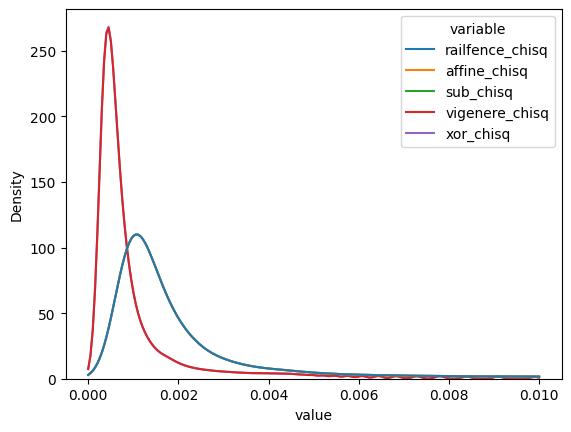

In [12]:
import seaborn as sns

inv_chi_df = df[['railfence_chisq', 'affine_chisq', 'sub_chisq', 'vigenere_chisq', 'xor_chisq']].melt()
sns.kdeplot(inv_chi_df, x='value', hue='variable', clip=(0, .01))

In [13]:
# bigram_chisq_df = df[['railfence_bigram_chisq', 'affine_bigram_chisq', 'sub_bigram_chisq', 'vigenere_bigram_chisq', 'xor_bigram_chisq']].melt()
# sns.kdeplot(inv_chi_df, x='value', hue='variable', clip=(0,.02))

<Axes: xlabel='value', ylabel='Density'>

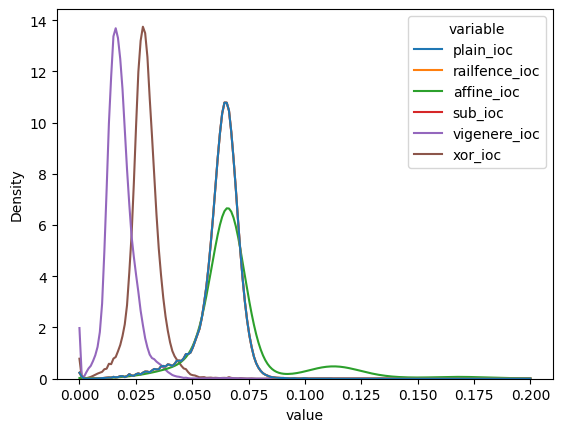

In [14]:
ioc_df = df[['plain_ioc', 'railfence_ioc', 'affine_ioc', 'sub_ioc', 'vigenere_ioc', 'xor_ioc']].melt()
sns.kdeplot(ioc_df, x='value', hue='variable', clip=(0, .2))

# plain == railfence == sub

<Axes: xlabel='value', ylabel='Density'>

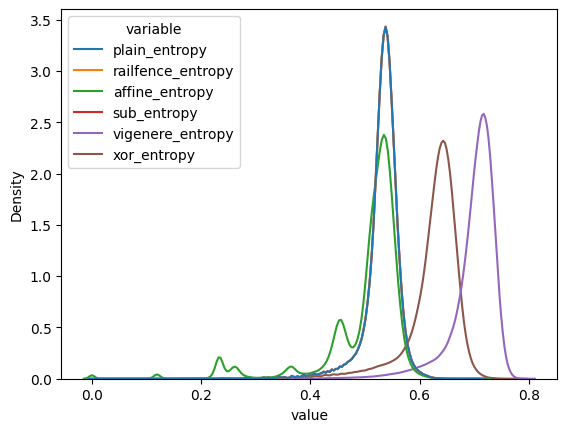

In [15]:
entropy_df = df[['plain_entropy', 'railfence_entropy', 'affine_entropy', 'sub_entropy', 'vigenere_entropy', 'xor_entropy']].melt()
sns.kdeplot(entropy_df, x='value', hue='variable')#, clip=(0, .2))


In [16]:
df.head()

,plaintext,plain_len,plain_chisq,plain_ioc,plain_entropy,railfence_chisq,railfence_ioc,railfence_entropy,affine_chisq,affine_ioc,affine_entropy,sub_chisq,sub_ioc,sub_entropy,vigenere_chisq,vigenere_ioc,vigenere_entropy,xor_chisq,xor_ioc,xor_entropy
0,"He wasn't home alone, apparently.",33,0.008086,0.047348,0.491326,0.008086,0.047348,0.491326,0.008086,0.056818,0.468599,0.008086,0.047348,0.491326,0.003324,0.018939,0.634430,0.003324,0.045455,0.508335
1,The St. Louis plant had to close. It would die...,153,0.001755,0.066993,0.536843,0.001755,0.066993,0.536843,0.001755,0.066993,0.536843,0.001755,0.066993,0.536843,0.000719,0.019952,0.697732,0.000719,0.028724,0.632366
2,WSU's plans quickly became a hot topic on loca...,177,0.001517,0.063238,0.533552,0.001517,0.063238,0.533552,0.001517,0.065614,0.521511,0.001517,0.063238,0.533552,0.000621,0.027735,0.708062,0.000621,0.040190,0.591744
3,The Alaimo Group of Mount Holly was up for a c...,498,0.000540,0.066455,0.554938,0.000540,0.066455,0.554938,0.000540,0.110971,0.460677,0.000540,0.066455,0.554938,0.000221,0.011555,0.754271,0.000221,0.027013,0.676718
4,And when it's often difficult to predict a law...,246,0.001092,0.067994,0.526535,0.001092,0.067994,0.526535,0.001092,0.067994,0.526535,0.001092,0.067994,0.526535,0.000447,0.012743,0.733746,0.000447,0.031724,0.634662


In [17]:
plain_df = df[['plain_chisq', 'plain_ioc', 'plain_entropy']]
plain_df.rename(columns={"plain_chisq": "inv_chi_sq", "plain_ioc": "ioc", 'plain_entropy':"entropy"}, inplace=True)
plain_df['type'] = plain_df.apply(lambda r: "plaintext", axis=1)

rail_df = df[['railfence_chisq', 'railfence_ioc', 'railfence_entropy']]
rail_df.rename(columns={"railfence_chisq": "inv_chi_sq", "railfence_ioc": "ioc", "railfence_entropy": "entropy"}, inplace=True)
rail_df['type'] = rail_df.apply(lambda r: "railfence", axis=1)

affine_df = df[['affine_chisq', 'affine_ioc', 'affine_entropy']]
affine_df.rename(columns={"affine_chisq": "inv_chi_sq", "affine_ioc": "ioc", "affine_entropy": "entropy"}, inplace=True)
affine_df['type'] = affine_df.apply(lambda r: "affine", axis=1)

sub_df = df[['sub_chisq', 'sub_ioc', 'sub_entropy']]
sub_df.rename(columns={"sub_chisq": "inv_chi_sq", "sub_ioc": "ioc", "sub_entropy": "entropy"}, inplace=True)
sub_df['type'] = sub_df.apply(lambda r: "substitution", axis=1)

vigenere_df = df[['vigenere_chisq', 'vigenere_ioc', 'vigenere_entropy']]
vigenere_df.rename(columns={"vigenere_chisq": "inv_chi_sq", "vigenere_ioc": "ioc", "vigenere_entropy": "entropy"}, inplace=True)
vigenere_df['type'] = vigenere_df.apply(lambda r: "vigenere", axis=1)

xor_df = df[['xor_chisq', 'xor_ioc', 'xor_entropy']]
xor_df.rename(columns={"xor_chisq": "inv_chi_sq", "xor_ioc": "ioc", "xor_entropy":"entropy"}, inplace=True)
xor_df['type'] = xor_df.apply(lambda r: "xor", axis=1)

detect_df = pd.concat([plain_df, rail_df, affine_df, sub_df, vigenere_df, xor_df])

del plain_df
del rail_df
del affine_df
del sub_df
del vigenere_df
del xor_df

detect_df.describe()

,inv_chi_sq,ioc,entropy
count,6.058848e+06,6.058848e+06,6.058848e+06
mean,2.144845e-03,5.298929e-02,5.701071e-01
std,3.410297e-03,3.865543e-02,8.416075e-02
min,9.666516e-06,0.000000e+00,-0.000000e+00
25%,6.946072e-04,2.878985e-02,5.257489e-01
50%,1.163147e-03,5.974026e-02,5.462602e-01
75%,2.018473e-03,6.657652e-02,6.310638e-01
max,5.105330e-02,1.000000e+00,8.029111e-01


<Axes: xlabel='inv_chi_sq', ylabel='ioc'>

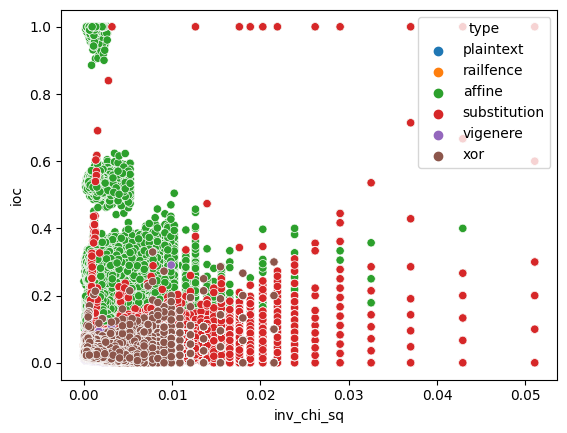

In [18]:
sns.scatterplot(detect_df, x='inv_chi_sq', y='ioc', hue='type')

<Axes: xlabel='entropy', ylabel='ioc'>

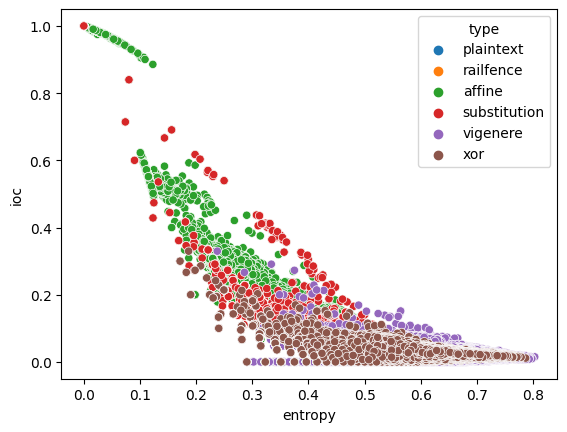

In [19]:
sns.scatterplot(detect_df, x='entropy', y='ioc', hue='type')

<Axes: xlabel='entropy', ylabel='inv_chi_sq'>

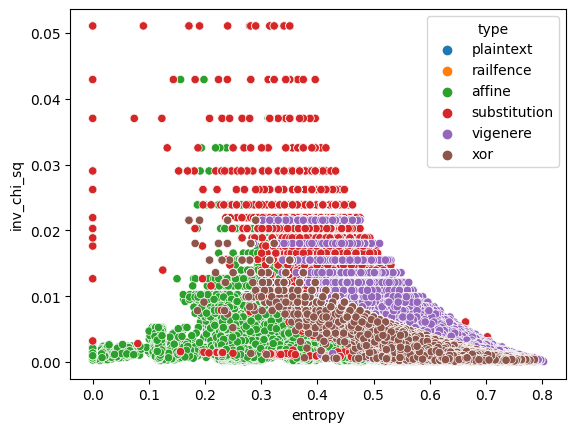

In [20]:
sns.scatterplot(detect_df, x='entropy', y='inv_chi_sq', hue='type')

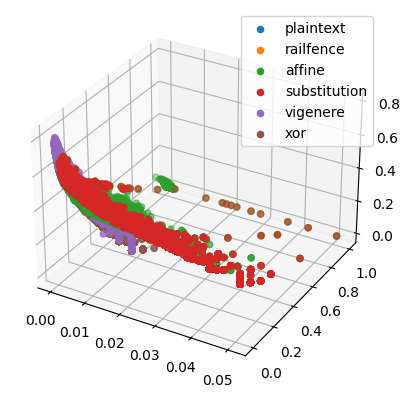

In [21]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for t in detect_df.type.unique():
    ax.scatter(detect_df.inv_chi_sq[detect_df.type==t], detect_df.ioc[detect_df.type==t], detect_df.entropy[detect_df.type==t], label=t)
ax.legend()
plt.show()


In [22]:
detect_df = detect_df[detect_df['type'] != 'plaintext']
detect_df.head()

,inv_chi_sq,ioc,entropy,type
0,0.008086,0.047348,0.491326,railfence
1,0.001755,0.066993,0.536843,railfence
2,0.001517,0.063238,0.533552,railfence
3,0.000540,0.066455,0.554938,railfence
4,0.001092,0.067994,0.526535,railfence


In [23]:
detect_df['type'].value_counts()

the groupby keys will be sorted anyway, although the 'sort=False' was passed. See the following issue for more details: https://github.com/modin-project/modin/issues/3571.


type
affine          1009808
railfence       1009808
substitution    1009808
vigenere        1009808
xor             1009808
Name: count, dtype: int64

In [24]:
# import numpy as np

# plain == railfence == sub
labels = {
    'railfence': 0,
    'affine': 1,
    'substitution':2,
    'vigenere': 3,
    'xor': 4
}

# detect_df['label'] = detect_df.apply(lambda r: labels[r['type']], axis=1)
# detect_df.drop(['type'], axis=1, inplace=True)

X = detect_df[['inv_chi_sq', 'ioc', 'entropy']].to_numpy()
Y = np.array([labels[t] for t in detect_df['type']])

In [25]:
results_df = pd.DataFrame(columns=["model_type", "training_score", "cross_valid_ave"])

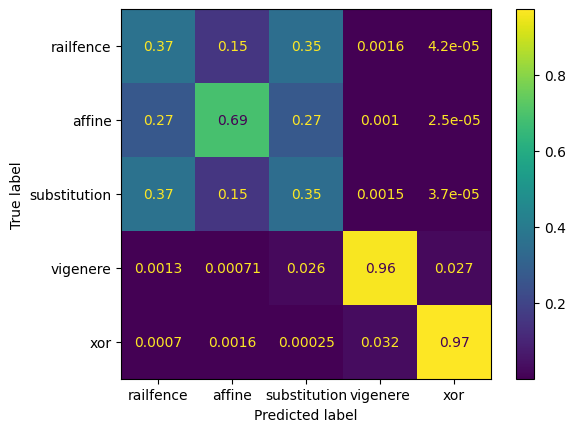

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from joblib import Parallel, delayed
from sklearn.model_selection import cross_val_score

n_cores = 16

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.8, random_state=1337)

svc = make_pipeline(StandardScaler(), SVC())

svc.fit(X_train, Y_train)

samples = X_test.shape[0]
parallel = Parallel(n_jobs=n_cores)
Y_hat = parallel(delayed(svc.predict)(X_test[(samples//n_cores) * i:(samples//n_cores) * (i+1)]) for i in range(n_cores))
Y_hat = np.vstack(Y_hat)
Y_hat = np.resize(Y_hat, Y_test.shape)
labels_ids = [k for k in labels.keys()]
ConfusionMatrixDisplay.from_predictions(Y_test, Y_hat, normalize='pred', display_labels=labels_ids)



In [27]:
import skops.io as sio

sio.dump(svc, "svc_detect.skops")

score = svc.score(X_train, Y_train)
print(f"score: {score}")
cross = cross_val_score(svc, X_train, Y_train, n_jobs=n_cores).mean()

results_df = pd.concat([pd.DataFrame([["svc", score, cross]], columns=results_df.columns), results_df], ignore_index=True)


score: 0.6376182402991459


score: 0.8956970037868585


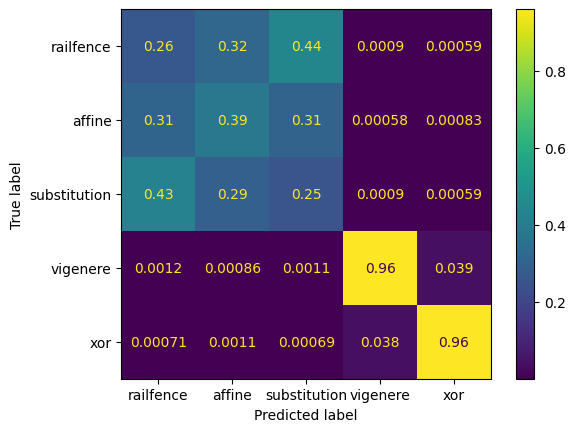

In [28]:
# TODO
# try other classifiers

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
# make_pipeline(StandardScaler(), SVC())

tree = make_pipeline(StandardScaler(), DecisionTreeClassifier())
tree.fit(X_train, Y_train)
Y_hat = parallel(delayed(tree.predict)(X_test[(samples//n_cores) * i:(samples//n_cores) * (i+1)]) for i in range(n_cores))
Y_hat = np.vstack(Y_hat)
Y_hat = np.resize(Y_hat, Y_test.shape)
score = tree.score(X_train, Y_train)
print(f"score: {score}")
ConfusionMatrixDisplay.from_predictions(Y_test, Y_hat, normalize='pred', display_labels=labels_ids)
cross = cross_val_score(tree, X_train, Y_train, n_jobs=n_cores).mean()
results_df = pd.concat([pd.DataFrame([["tree", score, cross]], columns=results_df.columns), results_df], ignore_index=True)
sio.dump(tree, "tree_detect.skops")



score: 0.7307072235514078


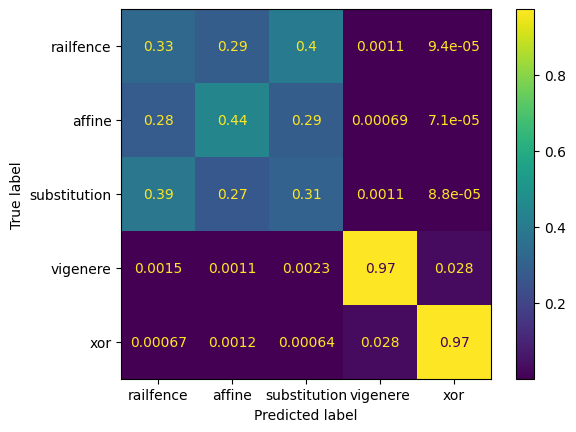

In [29]:
kneighbor = make_pipeline(StandardScaler(), KNeighborsClassifier())
kneighbor.fit(X_train, Y_train)
Y_hat = parallel(delayed(kneighbor.predict)(X_test[(samples//n_cores) * i:(samples//n_cores) * (i+1)]) for i in range(n_cores))
Y_hat = np.vstack(Y_hat)
Y_hat = np.resize(Y_hat, Y_test.shape)
score = kneighbor.score(X_train, Y_train)
print(f"score: {score}")
ConfusionMatrixDisplay.from_predictions(Y_test, Y_hat, normalize='pred', display_labels=labels_ids)
cross = cross_val_score(kneighbor, X_train, Y_train, n_jobs=n_cores).mean()
results_df = pd.concat([pd.DataFrame([["kneighbor", score, cross]], columns=results_df.columns), results_df], ignore_index=True)
sio.dump(kneighbor, "kneighbor_detect.skops")

score: 0.7609614897089347


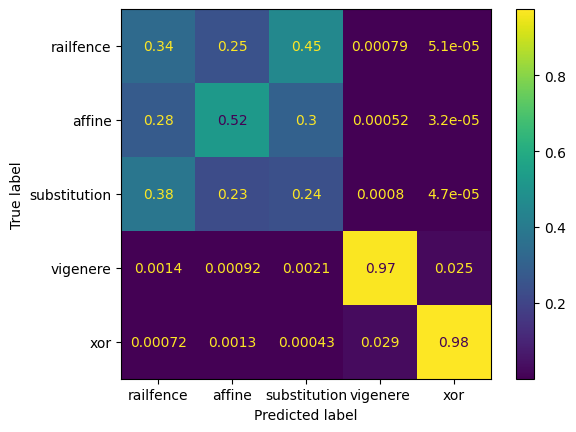

In [30]:
from sklearn.ensemble import VotingClassifier

vote = VotingClassifier(estimators=[('svc', svc), ('tree', tree), ('kneighbor', kneighbor)], voting='hard')
vote.fit(X_train, Y_train)
Y_hat = parallel(delayed(vote.predict)(X_test[(samples//n_cores) * i:(samples//n_cores) * (i+1)]) for i in range(n_cores))
Y_hat = np.vstack(Y_hat)
Y_hat = np.resize(Y_hat, Y_test.shape)
score = vote.score(X_train, Y_train)
print(f"score: {score}")
ConfusionMatrixDisplay.from_predictions(Y_test, Y_hat, normalize='pred', display_labels=labels_ids)
cross = cross_val_score(vote, X_train, Y_train, n_jobs=n_cores).mean()
results_df = pd.concat([pd.DataFrame([["vote", score, cross]], columns=results_df.columns), results_df], ignore_index=True)
sio.dump(vote, "vote_detect.skops")

In [31]:
results_df

,model_type,training_score,cross_valid_ave
0,vote,0.760961,0.611997
1,kneighbor,0.730707,0.608533
2,tree,0.895697,0.572722
3,svc,0.637618,0.637007


Seems to be able to distinguish between Transposition/Monoalphabetic Substitution and Vigenere/XOR, but doesnt really do a great job within each group

so what if we just turned this into a binary classifiction of Transposition/Monoalphabetic Substitution VS Vigenere/XOR?
then just handle each subgroup from there using heursitics?

SVC seems to do the best, so going to use that

In [32]:
detect_df[['inv_chi_sq', 'ioc', 'entropy']]

,inv_chi_sq,ioc,entropy
0,0.008086,0.047348,0.491326
1,0.001755,0.066993,0.536843
2,0.001517,0.063238,0.533552
3,0.000540,0.066455,0.554938
4,0.001092,0.067994,0.526535
...,...,...,...
1010237,0.000382,0.028310,0.652328
1010238,0.000576,0.025462,0.664291
1010239,0.000361,0.034060,0.628205
1010240,0.000305,0.021853,0.705659


In [33]:
labels = {
    'railfence': 0,
    'affine': 0,
    'substitution':0,
    'vigenere': 1,
    'xor': 1
}

# detect_df['label'] = detect_df.apply(lambda r: labels[r['type']], axis=1)
# detect_df.drop(['type'], axis=1, inplace=True)

X = detect_df[['inv_chi_sq', 'ioc', 'entropy']].to_numpy()
Y = np.array([labels[t] for t in detect_df['type']])

In [34]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=1337)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.8, random_state=1337)
X_train, Y_train = rus.fit_resample(X_train, Y_train)

bin_svc = make_pipeline(StandardScaler(), SVC())

bin_svc.fit(X_train, Y_train)

samples = X_test.shape[0]


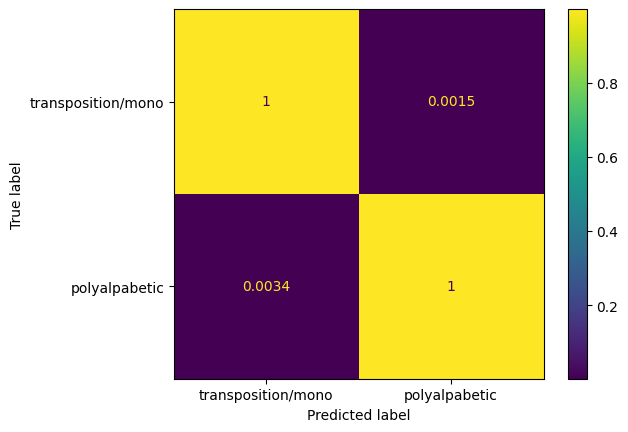

In [35]:
Y_hat = parallel(delayed(bin_svc.predict)(X_test[(samples//n_cores) * i:(samples//n_cores) * (i+1)]) for i in range(n_cores))
Y_hat = np.vstack(Y_hat)
Y_hat = np.resize(Y_hat, Y_test.shape)
labels_ids = ["transposition/mono", "polyalpabetic"]
ConfusionMatrixDisplay.from_predictions(Y_test, Y_hat, normalize='pred', display_labels=labels_ids)

In [36]:
sio.dump(bin_svc, "bin_svc_detect.skops")

score = bin_svc.score(X_train, Y_train)
print(f"score: {score}")
cross = cross_val_score(bin_svc, X_train, Y_train, n_jobs=n_cores).mean()
print(f"cross: {cross}")

score: 0.997053003883159
cross: 0.9970060102396674


In [37]:
labels = {
    'vigenere': 0,
    'xor': 1
}

polyalphabetic = detect_df[(detect_df['type'] == 'vigenere') | (detect_df['type'] == 'xor')]
polyalphabetic.describe()

,inv_chi_sq,ioc,entropy
count,2.019616e+06,2.019616e+06,2.019616e+06
mean,1.095423e-03,2.359076e-02,6.624849e-01
std,1.619155e-03,8.762802e-03,5.902587e-02
min,9.666516e-06,0.000000e+00,1.713688e-01
25%,4.089208e-04,1.694732e-02,6.309786e-01
50%,5.912883e-04,2.380178e-02,6.651091e-01
75%,9.904117e-04,2.940390e-02,7.090715e-01
max,2.153497e-02,3.296703e-01,8.029111e-01


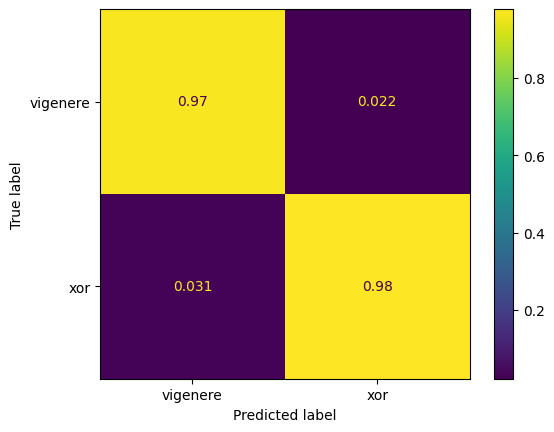

In [38]:

X = polyalphabetic[['inv_chi_sq', 'ioc', 'entropy']].to_numpy()
Y = np.array([labels[t] for t in polyalphabetic['type']])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.8, random_state=1337)
rus = RandomUnderSampler(random_state=1337)
X_train, Y_train = rus.fit_resample(X_train, Y_train)

poly_svc = make_pipeline(StandardScaler(), SVC())
poly_svc.fit(X_train, Y_train)
samples = X_test.shape[0]
Y_hat = parallel(delayed(poly_svc.predict)(X_test[(samples//n_cores) * i:(samples//n_cores) * (i+1)]) for i in range(n_cores))
Y_hat = np.vstack(Y_hat)
Y_hat = np.resize(Y_hat, Y_test.shape)
labels_ids = ["vigenere", "xor"]
ConfusionMatrixDisplay.from_predictions(Y_test, Y_hat, normalize='pred', display_labels=labels_ids)


In [39]:
sio.dump(poly_svc, "poly_svc_detect.skops")

score = poly_svc.score(X_train, Y_train)
print(f"score: {score}")
cross = cross_val_score(poly_svc, X_train, Y_train, n_jobs=n_cores).mean()
print(f"cross: {cross}")

score: 0.9735140869858362
cross: 0.9733926243747273


In [40]:
labels = {
    'railfence': 0,
    'affine': 1,
    'substitution':2,
}

trans_mono = detect_df[(detect_df['type'] != 'vigenere') & (detect_df['type'] != 'xor')]

X = trans_mono[['inv_chi_sq', 'ioc', 'entropy']].to_numpy()
Y = np.array([labels[t] for t in trans_mono['type']])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.8, random_state=1337)
rus = RandomUnderSampler(random_state=1337)
X_train, Y_train = rus.fit_resample(X_train, Y_train)
trans_mono_svc = make_pipeline(StandardScaler(), SVC())
trans_mono_svc.fit(X_train, Y_train)
samples = X_test.shape[0]


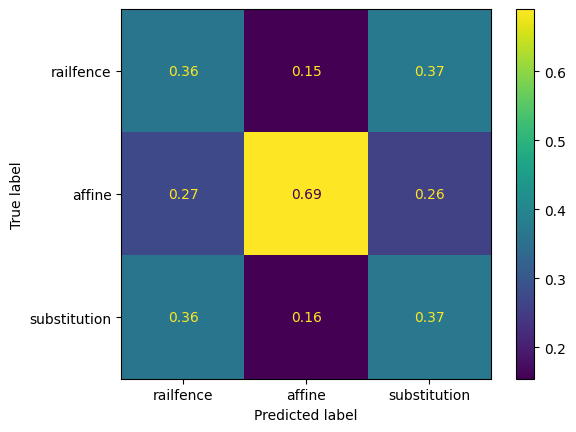

In [41]:
samples = X_test.shape[0]
n_cores = 16

parallel = Parallel(n_jobs=n_cores)
Y_hat = parallel(delayed(trans_mono_svc.predict)(X_test[(samples//n_cores) * i:(samples//n_cores) * (i+1)]) for i in range(n_cores))
Y_hat = np.vstack(Y_hat)
Y_hat = np.resize(Y_hat, Y_test.shape)
labels_ids = ["railfence", "affine", "substitution"]
ConfusionMatrixDisplay.from_predictions(Y_test, Y_hat, normalize='pred', display_labels=labels_ids)

In [42]:
sio.dump(trans_mono_svc, "trans_mono_svc_detect.skops")

score = trans_mono_svc.score(X_train, Y_train)
print(f"score: {score}")
cross = cross_val_score(trans_mono_svc, X_train, Y_train, n_jobs=n_cores).mean()
print(f"cross: {cross}")

score: 0.4177869802554018
cross: 0.4156668861220977


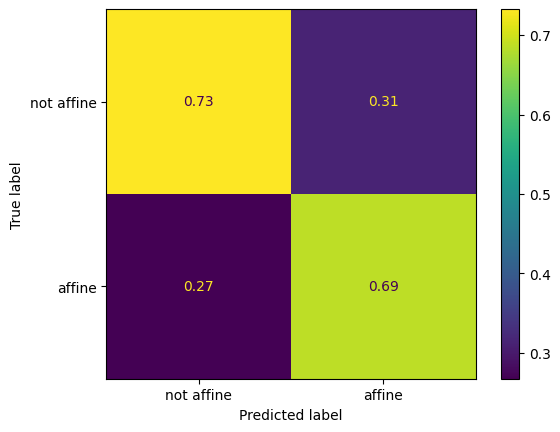

In [43]:
labels = {
    'railfence': 0,
    'affine': 1,
    'substitution':0,
}

affine_df = detect_df[(detect_df['type'] != 'vigenere') & (detect_df['type'] != 'xor')]

X = affine_df[['inv_chi_sq', 'ioc', 'entropy']].to_numpy()
Y = np.array([labels[t] for t in affine_df['type']])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.8, random_state=1337)
rus = RandomUnderSampler(random_state=1337)
X_train, Y_train = rus.fit_resample(X_train, Y_train)
affine_svc = make_pipeline(StandardScaler(), SVC())
affine_svc.fit(X_train, Y_train)
samples = X_test.shape[0]

Y_hat = parallel(delayed(affine_svc.predict)(X_test[(samples//n_cores) * i:(samples//n_cores) * (i+1)]) for i in range(n_cores))
Y_hat = np.vstack(Y_hat)
Y_hat = np.resize(Y_hat, Y_test.shape)
labels_ids = ["not affine", "affine"]
ConfusionMatrixDisplay.from_predictions(Y_test, Y_hat, normalize='pred', display_labels=labels_ids)

In [44]:
sio.dump(affine_svc, "affine_svc_detect.skops")

score = affine_svc.score(X_train, Y_train)
print(f"score: {score}")
cross = cross_val_score(affine_svc, X_train, Y_train, n_jobs=n_cores).mean()
print(f"cross: {cross}")

score: 0.6254758592694168
cross: 0.6252357614144695


: 